In [1]:
import torch
import os
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

In [2]:
image_size = 64
batch_size = 32


In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Download the img_align_celeba.zip and other files to data/celeba folder and then run the below cell

In [4]:
train_dataset = datasets.CelebA(root='data/', split='train', transform=transform, target_type='attr',download=True)
test_dataset = datasets.CelebA(root='data/', split='test', transform=transform, target_type='attr',download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_dataset, test_dataset

(Dataset CelebA
     Number of datapoints: 162770
     Root location: data/
     Target type: ['attr']
     Split: train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(64, 64))
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CelebA
     Number of datapoints: 19962
     Root location: data/
     Target type: ['attr']
     Split: test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(64, 64))
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [6]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, drop_last=True)

In [7]:
device = 'cpu' # set device = "cuda"

In [8]:
class ConditionalVAE(nn.Module):

    def __init__(self,
                 in_channels: int,
                 num_classes: int,
                 latent_dim: int,
                 encoder_dims: list,
                 decoder_dims: list,
                 img_size:int = 64,
                 **kwargs) -> None:
        super(ConditionalVAE, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = img_size

        self.embedd_class = nn.Linear(num_classes, img_size * img_size)
        self.embed_data = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        modules = []
        self.encoder = nn.ModuleList()
        in_channels += 1 # To account for the extra label channel
        for i in encoder_dims:
            self.encoder.append(
                nn.Conv2d(in_channels, out_channels=i,
                          kernel_size=3,stride=2, padding=1)
            )
            self.encoder.append(nn.LeakyReLU())

            in_channels = i

        self.encoder = nn.Sequential(*self.encoder)
        self.fc_mu = nn.Linear(encoder_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(encoder_dims[-1]*4, latent_dim)


        # Build Decoder

        self.decoder_input = nn.Linear(latent_dim + num_classes, encoder_dims[-1] * 4)

        self.decoder = nn.ModuleList()

        decoder_in_channel = encoder_dims[-1]
        for i in range(len(decoder_dims)):

            self.decoder.append(
                nn.ConvTranspose2d(decoder_in_channel,
                                       decoder_dims[i],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
            )

            self.decoder.append(
                nn.LeakyReLU()
            )

            decoder_in_channel = decoder_dims[i]


        self.decoder = nn.Sequential(*self.decoder)

        self.final_layer = nn.Sequential(
                            nn.Conv2d(decoder_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input) :
       
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z) :
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar) :

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, c) :
        embedded_class = self.embedd_class(c) # Embedding 40 -> 64*64
        embedded_class = embedded_class.view(-1, self.img_size, self.img_size).unsqueeze(1) # reshape to (1,64,64)
        # embedded_input = self.embed_data(input)

        x = torch.cat([input, embedded_class], dim = 1)
        mu, log_var = self.encode(x)

        z = self.reparameterize(mu, log_var)

        z = torch.cat([z, c], dim = 1)
        return  self.decode(z), mu, log_var

    

In [9]:
model = ConditionalVAE(3, 40, 128, [32, 64, 128, 256, 512], [256, 128, 64, 32, 32])
model.to(device)

ConditionalVAE(
  (embedd_class): Linear(in_features=40, out_features=4096, bias=True)
  (embed_data): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
  (fc_var): Linear(in_features=2048, out_features=128, bias=True)
  (decoder_input): Linear(in_features=168, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): Con

In [10]:
def loss_function(input, recons, mu, log_var):
    recons_loss =F.mse_loss(recons, input)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    loss = recons_loss + kld_loss
    return loss

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    for batch, (X, y) in enumerate(data_loader):
        # Send training data to CPU or GPU
        X = X.to(torch.float32)
        y = y.to(torch.float32)
        X, y = X.to(device), y.to(device)
        # Forward pass
        X_hat, mu, log_var = model(X,y) 

        # Calculate loss
        loss = loss_function(X, X_hat, mu, log_var)
        # print(loss)
        train_loss += loss

        # Grad of optimizer to zero (optimization the weights)
        optimizer.zero_grad()

        # Update the weights by backpropagation
        loss.backward()
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    # train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}\n")
    return train_loss.to('cpu').detach().numpy()

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in evaluation mode

    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send testing data to CPU or GPU
            X = X.to(torch.float32)
            y = y.to(torch.float32)
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            X_hat, X, mu, log_var = model(X,y)
            
            # Calculate loss and accuracy
            test_loss += loss_function(X, X_hat, mu, log_var)
    
        test_loss /= len(data_loader)
        # test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f}\n")
        return test_loss.detach().numpy()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
epochs = 20

train_plot = []
test_plot = []

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_loss, train_acc = train_step(data_loader=train_data_loader, 
        model=model, 
        optimizer=optimizer
    )
    
    train_plot.append((train_acc, train_loss))

    test_loss, test_acc = test_step(data_loader=test_data_loader,
        model=model,
    )
    test_plot.append((test_acc, test_loss))

In [10]:
model.load_state_dict(torch.load('CVAE_12.pth' , map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
test_image, test_attr = next(iter(test_data_loader))

In [19]:
attributes = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
attributes = attributes.split()

In [20]:
model.eval()

test_attr = test_attr.to(torch.float32)
test_attr = test_attr.to(device)

test_image = test_image.to(torch.float32)
test_image = test_image.to(device)


embedded_class = model.embedd_class(test_attr) # Embedding 40 -> 64*64
embedded_class = embedded_class.view(-1, 64, 64).unsqueeze(1) # reshape to (1,64,64)

x = torch.cat([test_image, embedded_class], dim = 1)
[mu, log_var] = model.encode(x)

In [21]:
new_attr = torch.zeros(32,40)
smiling = attributes.index('Eyeglasses') 
for i in range(32):
  temp = test_attr[i]
  temp[smiling] = 1.0
  new_attr[i] = test_attr[i]


In [22]:
model.eval()
# z = model.reparameterize(mu, log_var)
torch.manual_seed(42)
z = torch.randn((32,128))
z = z.to(device)
new_attr = new_attr.to(device)
# embedded_class = model.embedd_class(new_attr)
z1 = torch.cat([z, new_attr], dim = 1)

modi_images = model.decode(z1)

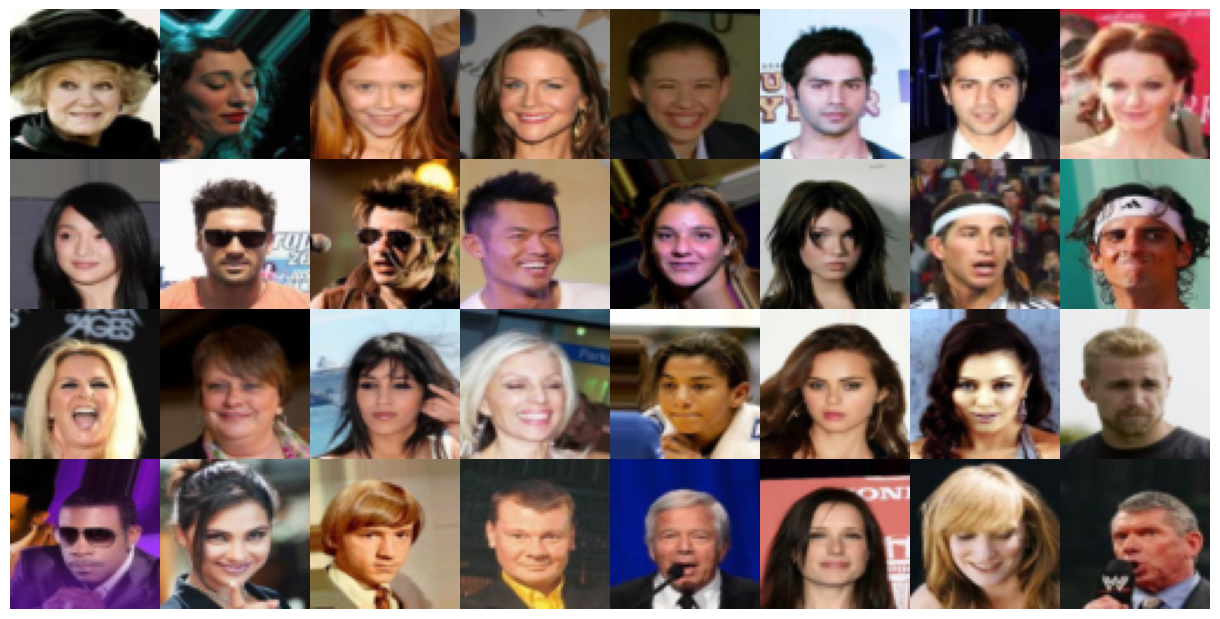

In [23]:
plt.figure(figsize=(12,6))
for i in range(len(test_image)):
  plt.subplot(4,8,i+1)
  img = torch.round((test_image[i].permute(1, 2, 0) + 1) * 255 / 2).to(torch.uint8)
  plt.imshow(img)
  plt.axis('off')
  # print(test_attr[i])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

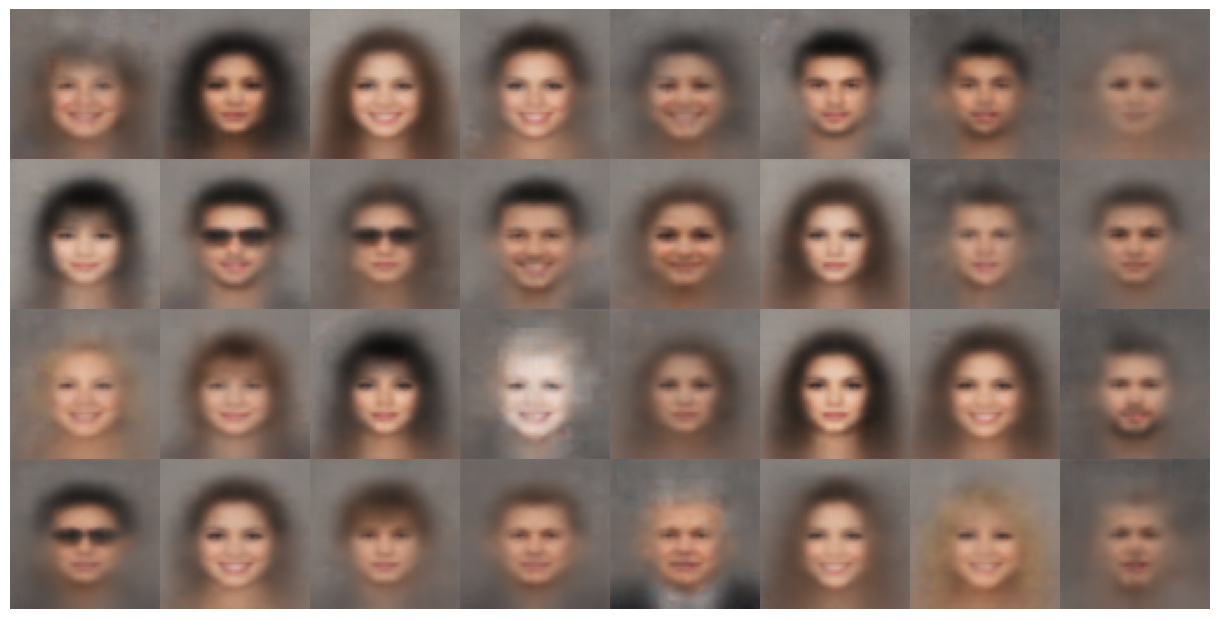

In [24]:
plt.figure(figsize=(12,6))

for i in range(len(test_image)):
    plt.subplot(4,8,i+1)
    img = modi_images.cpu().detach()[i].permute(1, 2, 0)
    img = torch.round((img + 1) * 255 / 2).to(torch.uint8)
    plt.imshow(img)
    plt.axis('off')
    
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)



## Morphying

In [25]:
four_images = [test_image[0], test_image[1], test_image[2], test_image[3]]

In [36]:
model = ConditionalVAE(3, 40, 128, [32, 64, 128, 256, 512], [256, 128, 64, 32, 32])
model.to(device)
model.load_state_dict(torch.load('CVAE_12.pth' , map_location=torch.device('cpu')))

<All keys matched successfully>

In [37]:
test_image, test_attr = next(iter(test_data_loader))

In [38]:
model.eval()

test_attr = test_attr.to(torch.float32)
test_attr = test_attr.to(device)

test_image = test_image.to(torch.float32)
test_image = test_image.to(device)


embedded_class = model.embedd_class(test_attr) # Embedding 40 -> 64*64
embedded_class = embedded_class.view(-1, 64, 64).unsqueeze(1) # reshape to (1,64,64)

x = torch.cat([test_image, embedded_class], dim = 1)
[mu, log_var] = model.encode(x)

In [54]:
mu_four_images = mu[0:2].clone()
log_var_four_images = log_var[0:2].clone()

In [55]:
delta = torch.linspace(0, 1, steps=8).unsqueeze(1).to(device)

In [56]:
new_mu = (1 - delta[:, None]) * mu_four_images[0] + delta[:, None] * mu_four_images[1]


In [62]:
new_mu.squeeze()

torch.Size([8, 128])

In [80]:
model.eval()
m_test = mu

z1 = torch.cat([new_mu.squeeze(), test_attr[0].repeat(8,1)], dim = 1)

modi_images = model.decode(z1)

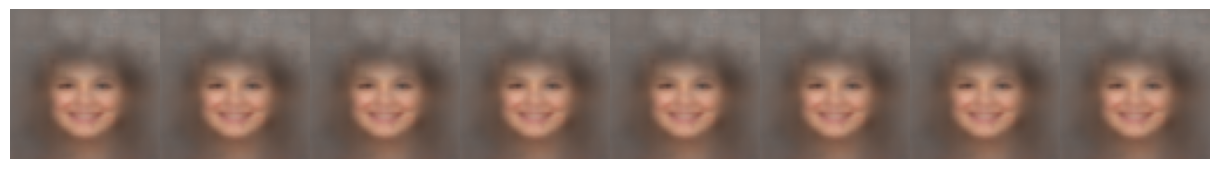

In [81]:
plt.figure(figsize=(12,6))

for i in range(8):
    plt.subplot(4,8,i+1)
    img = modi_images.cpu().detach()[i].permute(1, 2, 0)
    img = torch.round((img + 1) * 255 / 2).to(torch.uint8)
    plt.imshow(img)
    plt.axis('off')
    
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

